In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
#Load the data
train = pd.read_csv('../input/spooky-author-identification/train.zip', compression='zip')
test = pd.read_csv('../input/spooky-author-identification/test.zip', compression='zip')
submission = pd.read_csv('../input/spooky-author-identification/sample_submission.zip', compression='zip')

In [3]:
train.shape, test.shape, submission.shape

((19579, 3), (8392, 2), (8392, 4))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8392 non-null   object
 1   text    8392 non-null   object
dtypes: object(2)
memory usage: 131.2+ KB


EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64


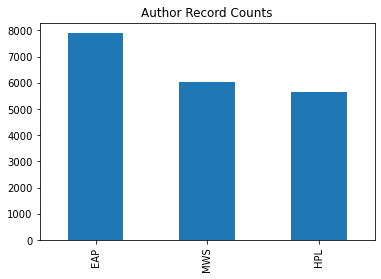

In [6]:
print(train.author.value_counts())
train.author.value_counts().plot(kind = 'bar', title = 'Author Record Counts')

In [7]:
train['label'] = 0
train.loc[train['author'] == 'EAP', 'label'] = 0
train.loc[train['author'] == 'HPL', 'label'] = 1
train.loc[train['author'] == 'MWS', 'label'] = 2
labels = keras.utils.to_categorical(train['label'], num_classes=3)

In [8]:
oov_token = "<OOV>"

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, oov_token=oov_token)
tokenizer.fit_on_texts(train['text'])
sequences = tokenizer.texts_to_sequences(train['text'])
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))
X = pad_sequences(sequences, maxlen=150, truncating='post')

Found 25944 unique tokens.


In [9]:
word_index

{'<OOV>': 1,
 'the': 2,
 'of': 3,
 'and': 4,
 'to': 5,
 'a': 6,
 'i': 7,
 'in': 8,
 'was': 9,
 'that': 10,
 'my': 11,
 'it': 12,
 'had': 13,
 'he': 14,
 'with': 15,
 'his': 16,
 'as': 17,
 'for': 18,
 'which': 19,
 'but': 20,
 'not': 21,
 'at': 22,
 'me': 23,
 'from': 24,
 'by': 25,
 'is': 26,
 'this': 27,
 'on': 28,
 'be': 29,
 'her': 30,
 'were': 31,
 'have': 32,
 'all': 33,
 'you': 34,
 'we': 35,
 'or': 36,
 'no': 37,
 'an': 38,
 'one': 39,
 'so': 40,
 'him': 41,
 'when': 42,
 'been': 43,
 'they': 44,
 'upon': 45,
 'there': 46,
 'could': 47,
 'she': 48,
 'its': 49,
 'would': 50,
 'more': 51,
 'now': 52,
 'their': 53,
 'what': 54,
 'some': 55,
 'our': 56,
 'are': 57,
 'into': 58,
 'than': 59,
 'will': 60,
 'very': 61,
 'who': 62,
 'if': 63,
 'them': 64,
 'only': 65,
 'then': 66,
 'up': 67,
 'these': 68,
 'before': 69,
 'about': 70,
 'any': 71,
 'time': 72,
 'man': 73,
 'yet': 74,
 'out': 75,
 'said': 76,
 'even': 77,
 'did': 78,
 'your': 79,
 'might': 80,
 'after': 81,
 'old': 82,
 '

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(X, labels, test_size = 0.1, random_state = 42)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((17621, 150), (1958, 150), (17621, 3), (1958, 3))

In [11]:
num_words = len(word_index)+1
emb_dim = 128

model = keras.models.Sequential([
    keras.layers.Embedding(num_words, emb_dim, input_length=X.shape[1]),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = True)),
    keras.layers.SpatialDropout1D(0.4),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 128)          3320960   
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 128)          98816     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 150, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 3,518,979
Trainable params: 3,518,979
Non-trainable params: 0
______________________________________________

In [12]:
epochs = 5
batch_size = 128
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(x_valid, y_valid),
                    callbacks=[callbacks])

Epoch 1/5
138/138 [==============================] - 11s 80ms/step - loss: 0.7562 - acc: 0.6578 - val_loss: 0.4711 - val_acc: 0.8131
Epoch 2/5
138/138 [==============================] - 10s 75ms/step - loss: 0.2821 - acc: 0.8986 - val_loss: 0.4378 - val_acc: 0.8289
Epoch 3/5
138/138 [==============================] - 10s 69ms/step - loss: 0.1384 - acc: 0.9535 - val_loss: 0.5069 - val_acc: 0.8212
Epoch 4/5
138/138 [==============================] - 10s 71ms/step - loss: 0.0917 - acc: 0.9703 - val_loss: 0.6028 - val_acc: 0.8080
Epoch 5/5
138/138 [==============================] - 10s 70ms/step - loss: 0.0738 - acc: 0.9761 - val_loss: 0.6296 - val_acc: 0.8156


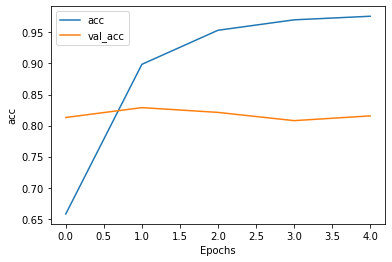

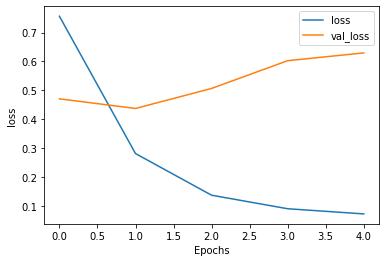

In [13]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

In [14]:
test = tokenizer.texts_to_sequences(test['text'])
x_test = pad_sequences(test, maxlen=150, truncating='post')
preds = model.predict(x_test)
preds

array([[3.3157284e-03, 5.0314114e-04, 9.9618113e-01],
       [9.9953938e-01, 2.3744388e-04, 2.2315087e-04],
       [1.0121206e-03, 9.9861002e-01, 3.7784129e-04],
       ...,
       [9.6227002e-01, 5.4328553e-03, 3.2297127e-02],
       [9.8346138e-01, 3.6020225e-03, 1.2936592e-02],
       [3.3137185e-04, 9.9952197e-01, 1.4664415e-04]], dtype=float32)

In [15]:
submission['EAP'] = preds[:,0]
submission['HPL'] = preds[:,1]
submission['MWS'] = preds[:,2]

In [16]:
submission.head()

,id,EAP,HPL,MWS
0,id02310,0.003316,0.000503,0.996181
1,id24541,0.999539,0.000237,0.000223
2,id00134,0.001012,0.998610,0.000378
3,id27757,0.997862,0.001484,0.000654
4,id04081,0.988542,0.002046,0.009412


In [17]:
submission.to_csv('submission.csv', index = False)